In [1]:
cd MF

/home/shse/Documents/sim_mf_bonne/MF


In [2]:
import numpy as np
import sys
#sys.path.append('mean_field_adapt')
#from transfer_functions.tf_simulation import single_experiment_2,single_experiment
from transfer_functions.load_config import load_transfer_functions,load_transfer_functions_with_ALL_params
from scipy.integrate import odeint
from single_cell_models.cell_library import get_neuron_params
from synapses_and_connectivity.syn_and_connec_library import get_connectivity_and_synapses_matrix
from transfer_functions.tf_simulation import reformat_syn_parameters
import matplotlib.pylab as plt

from scipy.optimize import fsolve
from scipy.optimize import minimize
import math

WARNING    "a" is an internal variable of group "neurongroup_1", but also exists in the run namespace with the value 0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "a" is an internal variable of group "neurongroup_2", but also exists in the run namespace with the value 0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "a" is an internal variable of group "neurongroup_3", but also exists in the run namespace with the value 0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "a" is an internal variable of group "neurongroup", but also exists in the run namespace with the value 0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


--##Start simulation##--
--##End simulation##--
9.264982491245622
48.681390695347666
9.03660580290145
48.742121060530266


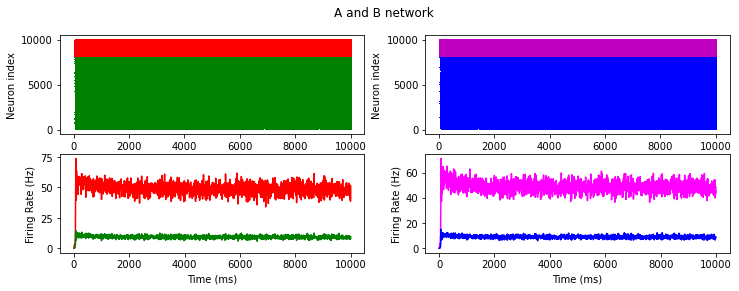

In [10]:

import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
import scipy.fftpack

def bin_array(array, BIN, time_array):
    N0 = int(BIN/(time_array[1]-time_array[0]))
    N1 = int((time_array[-1]-time_array[0])/BIN)
    return array[:N0*N1].reshape((N1,N0)).mean(axis=1)


start_scope()
DT=0.1 #fenetre de temps à modifier 
defaultclock.dt = DT*ms
N1 = 2000#2000
N2 = 8000#8000

TotTime=10000
duration = TotTime*ms



eqs='''
dv/dt = (-GsynE*(v-Ee)-GsynI*(v-Ei)-gl*(v-El)+ gl*Dt*exp((v-Vt)/Dt)-w + Is)/Cm : volt (unless refractory)
dw/dt = (a*(v-El)-w)/tau_w:ampere
dGsynI/dt = -GsynI/Tsyn : siemens
dGsynE/dt = -GsynE/Tsyn : siemens
Is:ampere
Cm:farad
gl:siemens
El:volt
a:siemens
tau_w:second
Dt:volt
Vt:volt
Ee:volt
Ei:volt
Tsyn:second
'''

# Populations----------------------------------------------------------------------------------

############################ First Adex FS-RS population 1-2 ####################################
# Population 1 - FS
b1 = 0.0*pA # no adaptation for FS 
G1 = NeuronGroup(N1, eqs, threshold='v > -47.5*mV', reset='v = -65*mV', refractory='5*ms', method='heun')
#
#init:
G1.v = -65*mV
G1.w = 0.0*pA
G1.GsynI=0.0*nS
G1.GsynE=0.0*nS
#parameters
G1.Cm = 200.*pF
G1.gl = 10.*nS
G1.El = -65.*mV
G1.Vt = -50.*mV
G1.Dt = 0.5*mV
G1.tau_w = 1.0*ms
G1.a = 0.0*nS
G1.Is = 0.0 #[0.0 for i in range(N1)]*nA

G1.Ee=0.*mV
G1.Ei=-80.*mV
G1.Tsyn=5.*ms

# Population 2 - RS
b2 = 1.*pA #adaptation for RS (slow adaptation or spike frequency adapatation)
G2 = NeuronGroup(N2, eqs, threshold='v > -40.0*mV', reset='v = -65*mV; w += b2', refractory='5*ms',  method='heun')
G2.v = -65.*mV
G2.w = 0.0*pA
G2.GsynI=0.0*nS
G2.GsynE=0.0*nS
G2.Cm = 200.*pF
G2.gl = 10.*nS
G2.El = -70.*mV
G2.Vt = -50.*mV
G2.Dt = 2.*mV
G2.tau_w = 1000.*ms
G2.a = 0.*nS
G2.Is = 0.0*nA #2.50*nA #[0.0 for i in range(N2)]*nA
#G2.Is[0]=0.*nA

G2.Ee=0.*mV
G2.Ei=-80.*mV
G2.Tsyn=5.*ms


# external drive-------------------------------------------------------------------------- Poisson distribution because of complex pattern of firing rate population spikes (fundamental hypothesis of the AdEx and because of chaos theory).

P_edA=PoissonGroup(8000, .8*Hz) #see what happens with external input on A network, compare witgh same input on B at the same time 

# connections-----------------------------------------------------------------------------

Qi=5.0*nS
Qe=1.9*nS #exc à 1.5*nS mean_fr à 0.04 hZ, 2.5 max pour 60 pA

prbC= 0.05 #0.05 => 5% of connectivity probability to explain (admit now, in research), "threshold to observe realisftic neural dynamics"
prbC2=0.05
S_12 = Synapses(G1, G2, on_pre='GsynI_post+=Qi') #'v_post -= 1.*mV'
S_12.connect('i!=j', p=prbC2)

S_11 = Synapses(G1, G1, on_pre='GsynI_post+=Qi')
S_11.connect('i!=j',p=prbC2)

S_21 = Synapses(G2, G1, on_pre='GsynE_post+=Qe')
S_21.connect('i!=j',p=prbC)

S_22 = Synapses(G2, G2, on_pre='GsynE_post+=Qe')
S_22.connect('i!=j', p=prbC)

#Synaptic Connections with external input and the inhibitors/excitators cells in B network 
#Si_inex2=[a for a in S_ed_inB.i] # inibitors-external input from neuron i
#Sj_inex2=[a for a in S_ed_inB.j] # inibitors-external input from neuron j
#Si_exex2=[a for a in S_ed_exB.i] # excitators-external input from neuron i
#Sj_exex2=[a for a in S_ed_exB.j] # excitators-external input from neuron j


############## #synapses from external drive to both populations of A network:
S_ed_inA = Synapses(P_edA, G1, on_pre='GsynE_post+=Qe') # Synapses receives the extrernal input in the A network, incremental quantal Qe because the external input is excitator 
#S_ed_inA.connect(i=Si_inex2, j=Sj_inex2) # synaptic connections of inibitors-external input of inibitors cells synapses connections
S_ed_inA.connect(p=prbC)

S_ed_exA = Synapses(P_edA, G2, on_pre='GsynE_post+=Qe')
S_ed_exA.connect(p=prbC)
#S_ed_exA.connect(i=Si_exex2, j=Sj_exex2) # synaptic connections of excitators-external input of inibitors cells synapses connections



Vtt=1 #Vtt => mean threshold of the membran potential of each adex

M1G1 = SpikeMonitor(G1)
M2G1 = StateMonitor(G1, 'v', record=range(Vtt))
M3G1 = StateMonitor(G1, 'w', record=range(Vtt))
M4G1 = StateMonitor(G1, 'GsynE', record=range(Vtt)) #monitoring of the synchronous conductance of the FS in G1
M5G1 = StateMonitor(G1, 'GsynI', record=range(Vtt)) #monitoring of the synchronous conductance of the RS in G1
FRG1 = PopulationRateMonitor(G1)

M1G2 = SpikeMonitor(G2)
M2G2 = StateMonitor(G2, 'v', record=range(Vtt))
M3G2 = StateMonitor(G2, 'w', record=range(Vtt))
M4G2 = StateMonitor(G2, 'GsynE', record=range(Vtt))
M5G2 = StateMonitor(G2, 'GsynI', record=range(Vtt))
FRG2 = PopulationRateMonitor(G2)

######################################################## Second ADEX FS-RS ##########################################################
##################################################################################################################

# Population 3 - FS
b3 = 0.0*pA
G3 = NeuronGroup(N1, eqs, threshold='v > -47.5*mV', reset='v = -65*mV', refractory='5*ms', method='heun')
#init:
G3.v = -65*mV
G3.w = 0.0*pA
G3.GsynI=0.0*nS
G3.GsynE=0.0*nS
#parameters
G3.Cm = 200.*pF
G3.gl = 10.*nS
G3.El = -65.*mV
G3.Vt = -50.*mV
G3.Dt = 0.5*mV
G3.tau_w = 1.0*ms
G3.a = 0.0*nS
G3.Is = 0.0 #[0.0 for i in range(N1)]*nA

G3.Ee=0.*mV
G3.Ei=-80.*mV
G3.Tsyn=5.*ms

# Population 4 - RS
b4 = 1.*pA
G4 = NeuronGroup(N2, eqs, threshold='v > -40.0*mV', reset='v = -65*mV; w += b4', refractory='5*ms',  method='heun')
G4.v = -65.*mV
G4.w = 0.0*pA
G4.GsynI=0.0*nS
G4.GsynE=0.0*nS
G4.Cm = 200.*pF
G4.gl = 10.*nS
G4.El = -70.*mV
G4.Vt = -50.*mV
G4.Dt = 2.*mV
G4.tau_w = 1000.*ms
G4.a = 0.*nS
G4.Is = 0.0*nA #2.50*nA #[0.0 for i in range(N2)]*nA
#G2.Is[0]=0.*nA

G4.Ee=0.*mV
G4.Ei=-80.*mV
G4.Tsyn=5.*ms

# external drive--------------------------------------------------------------------------

P_edB=PoissonGroup(8000, .8*Hz) #here we have only the external input in B network 

# connections-----------------------------------------------------------------------------

Qi=5.0*nS
Qe=1.9*nS

"""
#a mettre en commentaire pour test (structure pareille)
Si34=[a for a in S_12.i]
Sj34=[a for a in S_12.j]
Si33=[a for a in S_11.i]
Sj33=[a for a in S_11.j]
Si43=[a for a in S_21.i]
Sj43=[a for a in S_21.j]
Si44=[a for a in S_22.i]
Sj44=[a for a in S_22.j]
"""

prbC= 0.05 #0.05
prbC2=0.05
S_34 = Synapses(G3, G4, on_pre='GsynI_post+=Qi') #'v_post -= 1.*mV')
S_34.connect('i!=j', p=prbC)

S_33 = Synapses(G3, G3, on_pre='GsynI_post+=Qi')
S_33.connect('i!=j', p=prbC)

S_43 = Synapses(G4, G3, on_pre='GsynE_post+=Qe')
S_43.connect('i!=j', p=prbC)

S_44 = Synapses(G4, G4, on_pre='GsynE_post+=Qe')
S_44.connect('i!=j', p=prbC)

"""
#Synaptic Connections with external input and the inhibitors/excitators cells in A network 
Si_inex=[a for a in S_ed_inA.i] # inibitors-external input from neuron i
Sj_inex=[a for a in S_ed_inA.j] # inibitors-external input from neuron j
Si_exex=[a for a in S_ed_exA.i] # excitators-external input from neuron i
Sj_exex=[a for a in S_ed_exA.j] # excitators-external input from neuron j
"""


####### display Synaptic Connections with external input and the inhibitors/excitators cells in B network 
S_ed_inB = Synapses(P_edB, G3, on_pre='GsynE_post+=Qe')
#S_ed_inB.connect(i=Si_inex, j=Sj_inex) # synaptic connections of inibitors-external input of inibitors cells synapses connections in B
S_ed_inB.connect(p=prbC)


S_ed_exB = Synapses(P_edB, G4, on_pre='GsynE_post+=Qe')
#S_ed_exB.connect(i=Si_exex, j=Sj_exex) # synaptic connections of excitators-external input of excitatory cells synapses connections in B
S_ed_exB.connect(p=prbC)


Vtt=1

M1G3 = SpikeMonitor(G3)
M2G3 = StateMonitor(G3, 'v', record=range(Vtt))
M3G3 = StateMonitor(G3, 'w', record=range(Vtt))
M4G3 = StateMonitor(G3, 'GsynE', record=range(Vtt))
M5G3 = StateMonitor(G3, 'GsynI', record=range(Vtt))
FRG3 = PopulationRateMonitor(G3)

M1G4 = SpikeMonitor(G4)
M2G4 = StateMonitor(G4, 'v', record=range(Vtt))
M3G4 = StateMonitor(G4, 'w', record=range(Vtt))
M4G4 = StateMonitor(G4, 'GsynE', record=range(Vtt))
M5G4 = StateMonitor(G4, 'GsynI', record=range(Vtt))
FRG4 = PopulationRateMonitor(G4)


##################################################################################################################
##################################################################################################################


prbCBA=0.05

#Synaptic Connection from B (G3-G4) A (G1-G2) to  synapses 
#S_ABii = Synapses(G3, G1, on_pre='GsynI_post+=Qi')
#S_ABii.connect('i!=j',p=prbCBA)

#S_ABie = Synapses(G3, G2, on_pre='GsynI_post+=Qi')
#S_ABie.connect('i!=j',p=prbCBA)



S_ABei = Synapses(G4, G1, on_pre='GsynE_post+=Qe',delay=3*ms)
S_ABei.connect('i!=j',p=prbCBA)

S_ABee = Synapses(G4, G2, on_pre='GsynE_post+=Qe',delay=3*ms)
S_ABee.connect('i!=j',p=prbCBA)



##################################################################################################################
##################################################################################################################


#Synaptic Connection from A (G1-G2) to  B (G3-G4) synapses 
prbCAB=0.05
#
#S_BAii = Synapses(G1, G3, on_pre='GsynI_post+=Qi')
#S_BAii.connect('i!=j',p=prbCAB)
#
#S_BAie = Synapses(G1, G4, on_pre='GsynI_post+=Qi')
#S_BAie.connect('i!=j',p=prbCAB)
#
#
#
S_BAei = Synapses(G2, G3, on_pre='GsynE_post+=Qe',delay=3*ms)
S_BAei.connect('i!=j',p=prbCAB)
#
S_BAee = Synapses(G2, G4, on_pre='GsynE_post+=Qe',delay=3*ms)
S_BAee.connect('i!=j',p=prbCAB)



##################################################################################################################
##################################################################################################################

print('--##Start simulation##--')
run(duration)
print('--##End simulation##--')


# Plots -------------------------------------------------------------------------------


RasG1 = np.array([M1G1.t/ms, [i+N2 for i in M1G1.i]])
RasG2 = np.array([M1G2.t/ms, M1G2.i])


LVG1=[]
LwG1=[]
LVG2=[]
LwG2=[]

LgseG1=[]
LgsiG1=[]
LgseG2=[]
LgsiG2=[]

for a in range(Vtt):
    LVG1.append(array(M2G1[a].v/mV))
    LwG1.append(array(M3G1[a].w/mamp))
    LVG2.append(array(M2G2[a].v/mV))
    LwG2.append(array(M3G2[a].w/mamp))
    


BIN=5
time_array = np.arange(int(TotTime/DT))*DT



LfrG2=np.array(FRG2.rate/Hz)
TimBinned,popRateG2=bin_array(time_array, BIN, time_array),bin_array(LfrG2, BIN, time_array)

LfrG1=np.array(FRG1.rate/Hz)
TimBinned,popRateG1=bin_array(time_array, BIN, time_array),bin_array(LfrG1, BIN, time_array)



Lt1G1=array(M2G1.t/ms)
Lt2G1=array(M3G1.t/ms)
Lt1G2=array(M2G2.t/ms)
Lt2G2=array(M3G2.t/ms)



fig=plt.figure(figsize=(12,4))
fig.suptitle('A and B network')
#ax3=fig.add_subplot(223)
#ax4=fig.add_subplot(224)
"""
for a in range(len(LVG1)):
    ax1.plot(Lt1G1, LVG1[a],'r')
    ax2.plot(Lt2G1, LwG1[a],'r')
    ax1.plot(Lt1G2, LVG2[a],'g')
    ax2.plot(Lt2G2, LwG2[a],'g')


ax1.set_ylim([-100, 0])
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('$V_m$ (mV)') # v : membrane voltage 

ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('$w$ (pA)')# synapses weights 
"""
ax1=fig.add_subplot(221)
ax1.plot(RasG1[0], RasG1[1], ',r')
ax1.plot(RasG2[0], RasG2[1], ',g')

ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Neuron index')
ax2=fig.add_subplot(223)
ax2.plot(TimBinned,popRateG1, 'r')
ax2.plot(TimBinned,popRateG2, 'g')

ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Firing Rate (Hz)')




#######################################################
RasG3 = np.array([M1G3.t/ms, [i+N2 for i in M1G3.i]])
RasG4 = np.array([M1G4.t/ms, M1G4.i])


LVG3=[]
LwG3=[]
LVG4=[]
LwG4=[]

LgseG3=[]
LgsiG3=[]
LgseG4=[]
LgsiG4=[]

for a in range(Vtt):
    LVG3.append(array(M2G3[a].v/mV))
    LwG3.append(array(M3G3[a].w/mamp))
    LVG4.append(array(M2G4[a].v/mV))
    LwG4.append(array(M3G4[a].w/mamp))
    LgseG3.append(array(M4G3[a].GsynE/nS))
    LgsiG3.append(array(M5G3[a].GsynI/nS))
    LgseG4.append(array(M4G4[a].GsynE/nS))
    LgsiG4.append(array(M5G4[a].GsynI/nS))

BIN=5
time_array = np.arange(int(TotTime/DT))*DT



LfrG4=np.array(FRG4.rate/Hz)
TimBinned,popRateG4=bin_array(time_array, BIN, time_array),bin_array(LfrG4, BIN, time_array)

LfrG3=np.array(FRG3.rate/Hz)
TimBinned,popRateG3=bin_array(time_array, BIN, time_array),bin_array(LfrG3, BIN, time_array)



Lt1G3=array(M2G3.t/ms)
Lt2G3=array(M3G3.t/ms)
Lt1G4=array(M2G4.t/ms)
Lt2G4=array(M3G4.t/ms)
#LtgseG3=array(M4G3.t/ms)


#figB=plt.figure(figsize=(12,4))
#figB.suptitle('B network')
#ax1B=figB.add_subplot(221)
#ax2B=figB.add_subplot(222)
"""
for a in range(len(LVG3)):
    ax1B.plot(Lt1G1, LVG1[a],'r')
    ax2B.plot(Lt2G3, LwG3[a],'r')
    ax1B.plot(Lt1G4, LVG4[a],'g')
    ax2B.plot(Lt2G4, LwG4[a],'g')


ax1B.set_ylim([-100, 0])
ax1B.set_xlabel('Time (ms)')
ax1B.set_ylabel('$V_m$ (mV)') # v : membrane voltage 

ax2B.set_xlabel('Time (ms)')
ax2B.set_ylabel('$w$ (pA)')# synapses weights 
"""
ax2=fig.add_subplot(222)
ax2.plot(RasG3[0], RasG3[1], ',m')
ax2.plot(RasG4[0], RasG4[1], ',b')

ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Neuron index')
ax3=fig.add_subplot(224)
ax3.plot(TimBinned,popRateG3, 'magenta')
ax3.plot(TimBinned,popRateG4, 'blue')

ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Firing Rate (Hz)')

print(np.mean(popRateG2))
print(np.mean(popRateG1))
print(np.mean(popRateG4))
print(np.mean(popRateG3))

#1.5 nS et 1ms : AI
#0.05137844611528823
#1.3080200501253134
#0.04855889724310777
#1.3012531328320802

#1.9 nS 5ms
#10.051942355889723
#50.99824561403509
#9.457393483709273
#51.11353383458646

#1.7 => 2.3 ns 3ms lcei
#7.183208020050125
#36.855137844611534
#7.6188596491228076
#36.61303258145364


plt.show()

In [18]:
data=np.save('data.npy',[popRateG1,popRateG2,popRateG3,popRateG4,TimBinned])

In [3]:
data=np.load('data.npy')

In [121]:
popRateG3[1:10000].min()

0.1

No handles with labels found to put in legend.


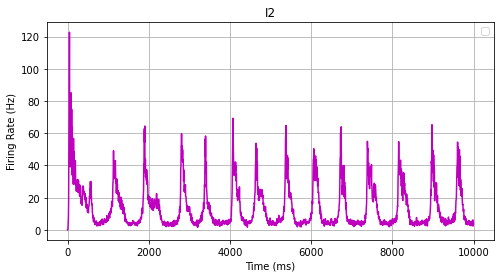

In [106]:
fig,ax=plt.subplots(figsize=(8, 4))

ax.plot(TimBinned,popRateG3,'m')
#ax.plot(data[4],data[1]*(1/3),'g')

ax.set_ylabel("Firing Rate (Hz)")
ax.set_xlabel("Time (ms)")
ax.grid(True)

ax.set_title('I2')
ax.legend()

In [96]:
print(np.argmax(LVG2[a]))

33401


In [150]:
LgseG4_bis=np.array(LgseG4,dtype=float)
LVG4_bis=np.array(LVG4,dtype=float)

No handles with labels found to put in legend.


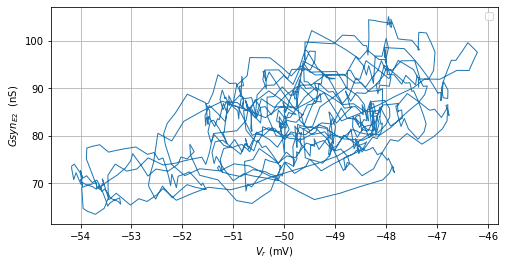

In [17]:
fig,ax=plt.subplots(figsize=(8, 4))

for a in range(Vtt):
    ax.plot(LVG4[a][1000:2000],LgseG4[a][1000:2000],lw=1)
    #ax.plot(Lt2G1, LwG1[a],'r')
    #ax.plot(Lt2G2, LwG2[a],'g')
    #ax2.plot(Lt2G2, LwG2[a],'g')

ax.set_ylabel("$Gsyn_{E2}$  (nS)")
ax.set_xlabel("$V_r$ (mV)")
ax.grid(True)

#ax.set_ylabel("Firing rates (Hz)")
ax.legend()
#ax.set_xlim(-49,-46)
#plt.plot(TimBinned[0:100],popRateG2[0:100],'g')
#plt.plot(TimBinned[0:100],popRateG4[0:100],'b')

No handles with labels found to put in legend.


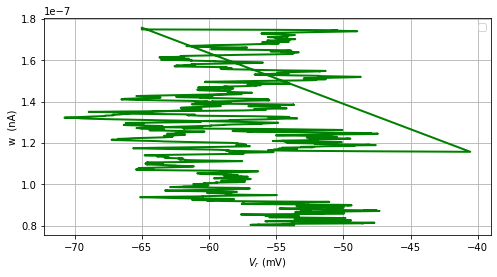

In [116]:
fig,ax=plt.subplots(figsize=(8, 4))

for a in range(len(LVG1)):
    ax.plot(LVG2[a][10000:20000],LwG2[a][10000:20000],'g',lw=2)
    #ax.plot(Lt2G1, LwG1[a],'r')
    #ax.plot(Lt2G2, LwG2[a],'g')
    #ax2.plot(Lt2G2, LwG2[a],'g')

ax.set_ylabel("w  (nA)")
ax.set_xlabel("$V_r$ (mV)")
ax.grid(True)

#ax.set_ylabel("Firing rates (Hz)")
ax.legend()
#ax.set_xlim(-49,-46)
#plt.plot(TimBinned[0:100],popRateG2[0:100],'g')
#plt.plot(TimBinned[0:100],popRateG4[0:100],'b')

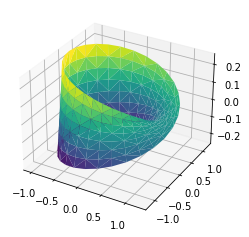

In [56]:
theta = np.linspace(0, 2 * np.pi, 30)
w = np.linspace(-0.25, 0.25, 8)
w, theta = np.meshgrid(w, theta)
phi = 0.5 * theta
# radius in x-y plane
r = 1 + w * np.cos(phi)

x = np.ravel(r * np.cos(theta))
y = np.ravel(r * np.sin(theta))
z = np.ravel(w * np.sin(phi))

from matplotlib.tri import Triangulation
tri = Triangulation(np.ravel(w), np.ravel(theta))

ax = plt.axes(projection='3d')
ax.plot_trisurf(x, y, z, triangles=tri.triangles,
                cmap='viridis', linewidths=0.2);

#ax.set_xlim(2, 8); ax.set_ylim(3, 7); ax.set_zlim(2, 8);

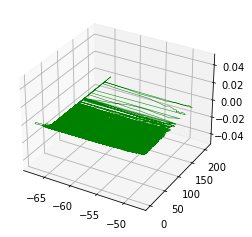

In [133]:
from mpl_toolkits import mplot3d
fig = plt.figure()
#zline = np.linspace(0, 100000)
ax = plt.axes(projection='3d')
for a in range(Vtt):
    ax.plot(LVG3[a],LgseG3[a],'g',lw=0.5)

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(4, 3))
sp = M1G2.i #commencer avec un 1er spike #par neuron
times = M1G2.t/ms
#duration=10000.*ms
nNeurons = max(sp) + 1
nSpikes = len(sp)

spiketimes = {}
for n in np.arange(nNeurons):
    ts = list(times[(np.where(sp == n))])
    #ts = [duration for duration in ts if duration > 500 * ms]
    spiketimes[n] = ts
isi_stds = []
isi_cvs = []
for n in range(nNeurons):
    isi_std = np.std(np.diff(spiketimes[n]))
    isi_cv = np.std(np.diff(spiketimes[n])) / np.mean(np.diff(spiketimes[n]))
    #axs[0].scatter(n, np.std(np.diff(spiketimes[n])))
    isi_stds.append(isi_std)  
    isi_cvs.append(isi_cv)
        
meanFiringRates = []
for n in range(nNeurons):
    meanFiringRates.append(1/np.mean(np.diff(spiketimes[n])))
        
    

axs[0].hist(isi_cvs, bins=15, alpha=0.9, edgecolor='black');
axs[1].hist(meanFiringRates, bins=10, alpha=0.9, edgecolor='black',color="green");
#for n in range(nNeurons):
    #axs[2].scatter(n, isi_std);

    
for k in range(1):
    leg = axs[k].legend(loc=1)
    leg.get_frame().set_facecolor('none')
    leg.get_frame().set_linewidth(0.0)
   
for k in range(2):
    axs[k].spines['right'].set_visible(False)
    axs[k].spines['top'].set_visible(False)
    axs[k].spines['bottom'].set_visible(False)
    axs[k].spines['left'].set_visible(False)
#axs[0].set_xticks([0, 0.5, 1.0])
#axs[1].set_yticks([0, 10, 20])

axs[0].set_xlim(0, 1.6)
axs[0].set_xlabel("CV$_{ISI}$")
axs[1].set_xlabel("Mean Firing Rates in HZ or [$s^{-1}$] ")

axs[0].set_ylabel("Neuron count")
axs[1].set_ylabel("Neuron count")

plt.subplots_adjust(hspace=0.5)

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(4, 3))
sp = M1G4.i #commencer avec un 1er spike #par neuron
times = M1G4.t/ms
#duration=10000.*ms
nNeurons = max(sp) + 1
nSpikes = len(sp)

spiketimes = {}
for n in np.arange(nNeurons):
    ts = list(times[(np.where(sp == n))])
    #ts = [duration for duration in ts if duration > 500 * ms]
    spiketimes[n] = ts
isi_stds = []
isi_cvs = []
for n in range(nNeurons):
    isi_std = np.std(np.diff(spiketimes[n]))
    isi_cv = np.std(np.diff(spiketimes[n])) / np.mean(np.diff(spiketimes[n]))
    #axs[0].scatter(n, np.std(np.diff(spiketimes[n])))
    isi_stds.append(isi_std)  
    isi_cvs.append(isi_cv)
        
meanFiringRates = []
for n in range(nNeurons):
    meanFiringRates.append(1/np.mean(np.diff(spiketimes[n])))
        
    

axs[0].hist(isi_cvs, bins=15, alpha=0.9, edgecolor='black');
axs[1].hist(meanFiringRates, bins=10, alpha=0.9, edgecolor='black',color="blue");
#for n in range(nNeurons):
    #axs[2].scatter(n, isi_std);

    
for k in range(1):
    leg = axs[k].legend(loc=1)
    leg.get_frame().set_facecolor('none')
    leg.get_frame().set_linewidth(0.0)
   
for k in range(2):
    axs[k].spines['right'].set_visible(False)
    axs[k].spines['top'].set_visible(False)
    axs[k].spines['bottom'].set_visible(False)
    axs[k].spines['left'].set_visible(False)
#axs[0].set_xticks([0, 0.5, 1.0])
#axs[1].set_yticks([0, 10, 20])

axs[0].set_xlim(0, 1.6)
axs[0].set_xlabel("CV$_{ISI}$")
axs[1].set_xlabel("Mean Firing Rates in HZ or [$s^{-1}$] ")

axs[0].set_ylabel("Neuron count")
axs[1].set_ylabel("Neuron count")

plt.subplots_adjust(hspace=0.5)